# 基于 PyTorch 的联邦学习包装（Wrap）教程
## 引言
在您阅读本教程之前，您需要预先学习 [使用Pytorch后端来进行联邦学习教程](https://www.secretflow.org.cn/docs/secretflow/latest/zh-Hans/tutorial/Federated_Learning_with_Pytorch_backend)，本教程是对使用Pytorch后端来进行联邦学习的深入，为了便于理解本教程，让我们再一次运行使用Pytorch后端来进行联邦学习的代码，并分析它的不足之处，从而引出本教程。
## 运行源代码

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import secretflow as sf

# Check the version of your SecretFlow
print('The version of SecretFlow: {}'.format(sf.__version__))

# In case you have a running secretflow runtime already.
sf.shutdown()

sf.init(['alice', 'bob', 'charlie'], address='local')
alice, bob, charlie = sf.PYU('alice'), sf.PYU('bob'), sf.PYU('charlie')

The version of SecretFlow: 1.3.0.dev20231109


2023-11-20 04:15:06,039	INFO worker.py:1538 -- Started a local Ray instance.


In [3]:
from secretflow.ml.nn.utils import BaseModule, TorchModel
from secretflow.ml.nn.fl.utils import metric_wrapper, optim_wrapper
from secretflow.ml.nn import FLModel
from torchmetrics import Accuracy, Precision
from secretflow.security.aggregation import SecureAggregator
from secretflow.utils.simulation.datasets import load_mnist
from torch import nn, optim
from torch.nn import functional as F

2023-11-20 04:15:08.679474: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/anaconda3/envs/limingbo_sf/lib/:/opt/anaconda3/envs/limingbo_sf/lib/python3.8/site-packages/nvidia/cudnn/lib
2023-11-20 04:15:08.679559: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/anaconda3/envs/limingbo_sf/lib/:/opt/anaconda3/envs/limingbo_sf/lib/python3.8/site-packages/nvidia/cudnn/lib
2023-11-20 04:15:08.679566: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned abo

In [4]:
class ConvNet(BaseModule):
    """Small ConvNet for MNIST."""

    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc_in_dim = 192
        self.fc = nn.Linear(self.fc_in_dim, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, self.fc_in_dim)
        x = self.fc(x)
        return F.softmax(x, dim=1)

In [5]:
(train_data, train_label), (test_data, test_label) = load_mnist(
    parts={alice: 0.4, bob: 0.6},
    normalized_x=True,
    categorical_y=True,
    is_torch=True,
)

loss_fn = nn.CrossEntropyLoss
optim_fn = optim_wrapper(optim.Adam, lr=1e-2)
model_def = TorchModel(
    model_fn=ConvNet,
    loss_fn=loss_fn,
    optim_fn=optim_fn,
    metrics=[
        metric_wrapper(Accuracy, task="multiclass", num_classes=10, average='micro'),
        metric_wrapper(Precision, task="multiclass", num_classes=10, average='micro'),
    ],
)

In [6]:
device_list = [alice, bob]
server = charlie
aggregator = SecureAggregator(server, [alice, bob])

# spcify params
fl_model = FLModel(
    server=server,
    device_list=device_list,
    model=model_def,
    aggregator=aggregator,
    strategy='fed_avg_w',  # fl strategy
    backend="torch",  # backend support ['tensorflow', 'torch']
)

INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party bob.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party bob.


In [7]:
history = fl_model.fit(
    train_data,
    train_label,
    validation_data=(test_data, test_label),
    epochs=20,
    batch_size=32,
    aggregate_freq=1,
)

INFO:root:FL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2da4848a00>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f2da4865430>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2da4865400>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f2da48656d0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 32, 'batch_sampling_rate': None, 'epochs': 20, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2da48657c0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f2da4865b80>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2d

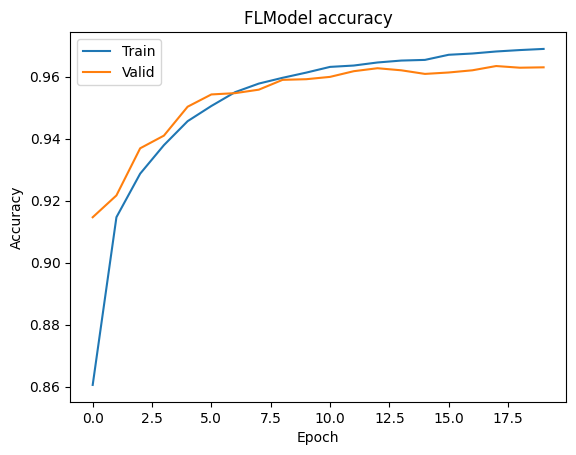

In [8]:
from matplotlib import pyplot as plt

# Draw accuracy values for training & validation
plt.plot(history.global_history['multiclassaccuracy'])
plt.plot(history.global_history['val_multiclassaccuracy'])
plt.title('FLModel accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [9]:
old_keys = history.global_history.keys()
old_keys

dict_keys(['multiclassaccuracy', 'multiclassprecision', 'val_multiclassaccuracy', 'val_multiclassprecision'])

## 问题引出
可以看到在模型定义的过程中，我们对优化器（optimizer）和衡量指标（metric）进行了（wrap）包装,
```python
optim_fn = optim_wrapper(optim.Adam, lr=1e-2)
```
```python
model_def = TorchModel(
    model_fn=ConvNet,
    loss_fn=loss_fn,
    optim_fn=optim_fn,
    metrics=[
        metric_wrapper(Accuracy, task="multiclass", num_classes=10, average='micro'),
        metric_wrapper(Precision, task="multiclass", num_classes=10, average='micro'),
    ],
)
```
从而实现了对优化器（optimizer）的使用，并且直接包装衡量指标（metric）的包装使得我们不需要自己调用繁琐的指标计算过程，但是原教程并没有详细叙述包装原理，因此本教程详细分解这一过程，并且实现自定义包装损失函数（loss function）。

## 包装原理解析
通过上述的函数调用可以看到我们分别，通过`optim_wrapper`和`metric_wrapper`进行优化器（optimizer）和衡量指标（metric）的包装，并且通过追根溯源，我们可以看到
```python
from secretflow.ml.nn.fl.utils import metric_wrapper, optim_wrapper
```
可以看到这两个函数来自于`secretflow.ml.nn.fl.utils`，让我们去阅读一下它的[源代码](https://github.com/secretflow/secretflow/blob/main/secretflow/ml/nn/fl/utils.py#L94)
```python
def metric_wrapper(func, *args, **kwargs):
    def wrapped_func():
        return func(*args, **kwargs)

    return wrapped_func


def optim_wrapper(func, *args, **kwargs):
    def wrapped_func(params):
        return func(params, *args, **kwargs)

    return wrapped_func
```
可以看到这两个函数实质上是相同的，只是名称上不同，实际上都是通过传入一个需要包装的函数名称，位置参数和关键字参数对函数完成包装，然后返回包装好的函数；所以
```python
optim_fn = optim_wrapper(optim.Adam, lr=1e-2)
```
实际上相当于调用
```python
optim.Adam(lr=1e-2)
```
同时
```python
metric_wrapper(Accuracy, task="multiclass", num_classes=10, average='micro')
```
实际上相当于调用
```python
Accuracy(task="multiclass", num_classes=10, average='micro')
```
并且都通过关键字参数确保了指定的参数赋值；所以接下来，我们能分别完成自定义的优化器（optimizer）、衡量指标（metric）和损失函数（loss function）的包装。

## 自定义的优化器（optimizer）的包装
### PyTorch 的调用方式
为了自定义的优化器（optimizer）的包装，首先让我们看看 PyTorch 的调用方式是怎么样的，此处我们以 **[optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)** 为例，对于更多的优化器（optimizer）选择，您可以参考；[TORCH.OPTIM](https://pytorch.org/docs/stable/optim.html#algorithms)
可以看到，它在PyTorch的调用方式为

```python
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
optimizer.zero_grad()
loss_fn(model(input), target).backward()
optimizer.step()
```

### 隐语的自定义包装
得益于隐语的封装，此处我们仅仅需要关注
```python
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
```
即可，并且也是因为隐语封装 `model.parameters()` 并不需要我们在包装器内传入，所以在这里，`torch.optim.SGD` 是需要包装的函数， `lr=0.1` 和 `momentum=0.9` 是需要传入的参数，因此我们自定义的优化器（optimizer）只需要写成

In [10]:
sf_custom_optimizer = optim_wrapper(optim.SGD, lr=0.1, momentum=0.9)

### 测试
接下来，让我们测试一下我们自定义的优化器（optimizer）。

In [11]:
model_def = TorchModel(
    model_fn=ConvNet,
    loss_fn=loss_fn,
    # we only modify the line for custom optimizer
    # optim_fn=optim_fn,
    optim_fn=sf_custom_optimizer,
    metrics=[
        metric_wrapper(Accuracy, task="multiclass", num_classes=10, average='micro'),
        metric_wrapper(Precision, task="multiclass", num_classes=10, average='micro'),
    ],
)

In [12]:
# spcify params
fl_model = FLModel(
    server=server,
    device_list=device_list,
    model=model_def,
    aggregator=aggregator,
    strategy='fed_avg_w',  # fl strategy
    backend="torch",  # backend support ['tensorflow', 'torch']
)

INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party bob.


In [13]:
history = fl_model.fit(
    train_data,
    train_label,
    validation_data=(test_data, test_label),
    epochs=20,
    batch_size=32,
    aggregate_freq=1,
)

INFO:root:FL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2da4848a00>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f2da4865430>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2da4865400>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f2da48656d0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 32, 'batch_sampling_rate': None, 'epochs': 20, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2da48657c0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f2da4865b80>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2d

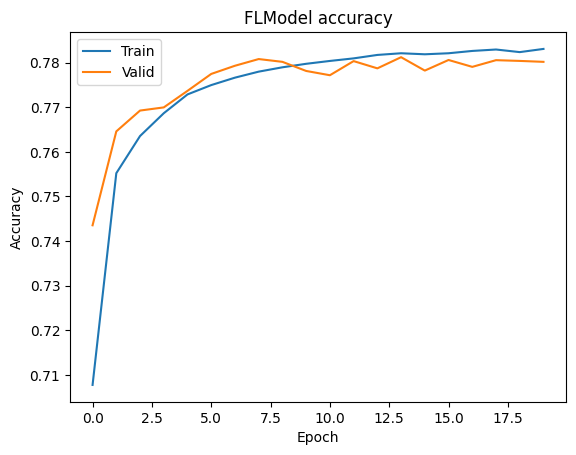

In [14]:
# Draw accuracy values for training & validation
plt.plot(history.global_history['multiclassaccuracy'])
plt.plot(history.global_history['val_multiclassaccuracy'])
plt.title('FLModel accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

### 小结
可以看到，通过包装，我们使用了我们自定义的优化器（optimizer），并且使得代码顺利运行。

## 自定义的衡量指标（metric）的包装
为了自定义的衡量指标（metric）的包装，首先让我们看看被包装的指标来自何处。
```python
from torchmetrics import Accuracy, Precision
```
```python
metrics=[
    metric_wrapper(Accuracy, task="multiclass", num_classes=10, average='micro'),
    metric_wrapper(Precision, task="multiclass", num_classes=10, average='micro'),
],
```
通过阅读代码可知，被包装的指标来自于 [TorchMetrics](https://torchmetrics.readthedocs.io/en/stable/) ，TorchMetrics 是 100+ PyTorch 指标实现和易于使用的 API 的集合，用于创建自定义指标。
### TorchMetrics 的调用方式
让我们看看 TorchMetrics 的调用方式是怎么样的，此处我们以 **[分类任务中的召回率](https://torchmetrics.readthedocs.io/en/stable/classification/recall.html)** 为例，对于更多的优衡量指标（metric）选择，您可以参考；[ALL TORCHMETRICS in TorchMetrics](https://torchmetrics.readthedocs.io/en/stable/all-metrics.html)
可以看到，它在 PyTorch 的调用方式为

```python
from torch import tensor
preds  = tensor([2, 0, 2, 1])
target = tensor([1, 1, 2, 0])
recall = Recall(task="multiclass", average='macro', num_classes=3)
recall(preds, target)
```

### 隐语的自定义包装
得益于隐语的封装，并且根据前述的包装原理可知，此处我们仅仅需要关注，因为实际上我们需要通过包装完成一个参数具体化的函数，所以在这里 `torchmetrics.Recall` 是需要包装的函数，`task="multiclass"`、`average='macro'`和`num_classes=3` 是需要传入的参数，因此我们自定义的衡量指标（metric）只需要写成
```python
metric_wrapper(Recall, task="multiclass", average='macro', num_classes=10)
```
其中，`num_classes=10` 是根据我们的任务自行设定

### 测试
接下来，让我们测试一下我们自定义的衡量指标（metric）。

In [15]:
from torchmetrics import Recall

model_def = TorchModel(
    model_fn=ConvNet,
    loss_fn=loss_fn,
    optim_fn=optim_fn,
    # here we add the metric Recall to show how to add more metrics.
    metrics=[
        metric_wrapper(Accuracy, task="multiclass", num_classes=10, average='micro'),
        metric_wrapper(Precision, task="multiclass", num_classes=10, average='micro'),
        metric_wrapper(Recall, task="multiclass", average='macro', num_classes=10)
    ],
)

In [16]:
# spcify params
fl_model = FLModel(
    server=server,
    device_list=device_list,
    model=model_def,
    aggregator=aggregator,
    strategy='fed_avg_w',  # fl strategy
    backend="torch",  # backend support ['tensorflow', 'torch']
)

INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party bob.


In [17]:
history = fl_model.fit(
    train_data,
    train_label,
    validation_data=(test_data, test_label),
    epochs=20,
    batch_size=32,
    aggregate_freq=1,
)

INFO:root:FL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2da4848a00>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f2da4865430>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2da4865400>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f2da48656d0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 32, 'batch_sampling_rate': None, 'epochs': 20, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2da48657c0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f2da4865b80>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2d

In [18]:
history.global_history.keys()

dict_keys(['multiclassaccuracy', 'multiclassprecision', 'multiclassrecall', 'val_multiclassaccuracy', 'val_multiclassprecision', 'val_multiclassrecall'])

In [19]:
old_keys

dict_keys(['multiclassaccuracy', 'multiclassprecision', 'val_multiclassaccuracy', 'val_multiclassprecision'])

可以看到，通过加入自定义的衡量指标（metric）,我们的训练历史里记录了更多的键值可供我们可视化，从而实现对模型的性能更加全面的认识。

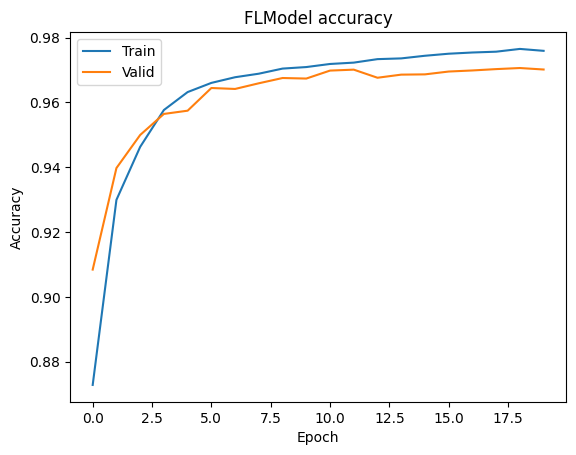

In [20]:
# Draw accuracy values for training & validation
plt.plot(history.global_history['multiclassaccuracy'])
plt.plot(history.global_history['val_multiclassaccuracy'])
plt.title('FLModel accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

让我们可视化模型的训练的召回率变化

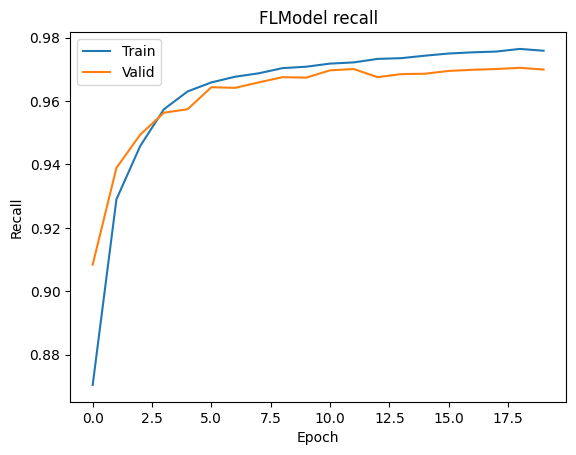

In [21]:
# Draw recall values for training & validation
plt.plot(history.global_history['multiclassrecall'])
plt.plot(history.global_history['val_multiclassrecall'])
plt.title('FLModel recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

### 小结
可以看到，通过包装，我们使用了我们自定义的衡量指标（metric），并且使得代码顺利运行。通过包装更多的衡量指标（metric），我们能对模型的性能有更全面的认识，能够在  SecretFlow 隐语的框架下，体会到和单机模式下，使用 PyTorch 编程几乎一致的体验。

## 自定义的损失函数（loss function）的包装
### 问题引入
通过对教程源代码的解析可知，我们虽然在之前构建联邦学习的过程中，调用了损失函数（loss function）`CrossEntropyLoss`，但是并没有通过传入参数使之更加具体化，我们所调用的损失函数实际上使用的是默认参数。
```python
loss_fn = nn.CrossEntropyLoss
model_def = TorchModel(
    model_fn=ConvNet,
    loss_fn=loss_fn,
    optim_fn=optim_fn,
    metrics=[
        metric_wrapper(Accuracy, task="multiclass", num_classes=10, average='micro'),
        metric_wrapper(Precision, task="multiclass", num_classes=10, average='micro'),
    ],
)
```

### PyTorch 的调用方式
然而在 PyTorch 的调用过程中，我们实际上可以通过传入参数具体化损失函数。通过阅读 [CrossEntropyLoss的文档可知](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)可知，其默认参数的取值为

```python
torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean', label_smoothing=0.0)
```
所以我们之前所传入的损失函数，实际上使用的就是上述默认参数。

### 隐语的自定义包装
让我们试着包装损失函数来对损失函数传入参数，使之具体化。
### 定义包装函数
参考 `optim_wrapper` 和 `metric_wrapper` 的定义方式，我们也可以自定义 `loss_function_wrapper`。

In [22]:
def loss_function_wrapper(func, *args, **kwargs):
    def wrapped_func():
        return func(*args, **kwargs)

    return wrapped_func

### 包装损失函数
得益于隐语的封装，并且根据前述的包装原理可知，此处我们仅仅需要关注，因为实际上我们需要通过包装完成一个参数具体化的函数，所以在这里 `nn.CrossEntropyLoss` 是需要包装的函数，并且其参数取值，就是需要传入的参数值。因为在其默认参数取值设置中，  `reduction='mean'` , 此处我们试着将其修改为 ` reduction='sum'`。包装损失函数只需要写成：

In [23]:
loss_wrapper = loss_function_wrapper(nn.CrossEntropyLoss, reduction='sum')

### 测试
接下来，让我们测试一下我们自定义的损失函数（loss function）

In [24]:
model_def = TorchModel(
    model_fn=ConvNet,
    # we only modify the following line for custom loss function
    loss_fn=loss_wrapper,
    # loss_fn=loss_fn,
    optim_fn=optim_fn,
    metrics=[
        metric_wrapper(Accuracy, task="multiclass", num_classes=10, average='micro'),
        metric_wrapper(Precision, task="multiclass", num_classes=10, average='micro'),
    ],
)

In [25]:
# spcify params
fl_model = FLModel(
    server=server,
    device_list=device_list,
    model=model_def,
    aggregator=aggregator,
    strategy='fed_avg_w',  # fl strategy
    backend="torch",  # backend support ['tensorflow', 'torch']
)

INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party bob.


In [26]:
history = fl_model.fit(
    train_data,
    train_label,
    validation_data=(test_data, test_label),
    epochs=20,
    batch_size=32,
    aggregate_freq=1,
)

INFO:root:FL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2da4848a00>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f2da4865430>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2da4865400>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f2da48656d0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 32, 'batch_sampling_rate': None, 'epochs': 20, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2da48657c0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f2da4865b80>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2d

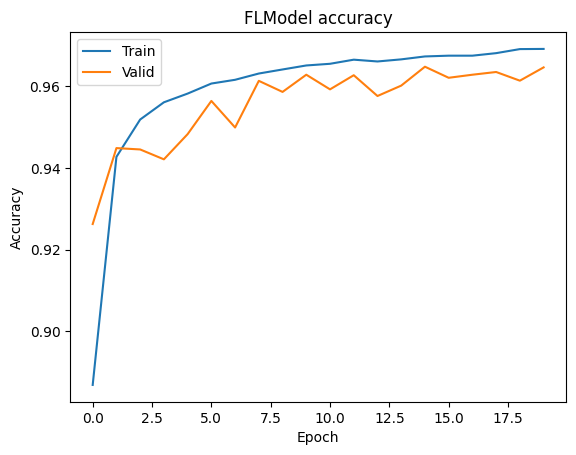

In [27]:
# Draw accuracy values for training & validation
plt.plot(history.global_history['multiclassaccuracy'])
plt.plot(history.global_history['val_multiclassaccuracy'])
plt.title('FLModel accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

### 小结
可以看到，通过包装，我们使用了我们自定义的损失函数（loss function），并且使得代码顺利运行。可以看到通过将 `reduction='mean'` 修改为 ` reduction='sum'`，让它使用了不同的方式计算损失。

## 总结
可以看到，通过包装，我们使用了我们自定义的优化器（optimizer）、衡量指标（metric）和损失函数（loss function）。
通过：
- 自定义的优化器（optimizer），我们可以传入参数，具体化各种优化器（optimizer）来实现对模型的优化。
- 自定义的衡量指标（metric），我们可以根据任务类型包装各种各样的指标，从而实现对模型的性能有更全面的认识。
- 自定义的损失函数（loss function），我们可以通过参数具体化我们的损失函数调用。

总之，通过包装，我们能够在  SecretFlow 隐语的框架下，体会到和单机模式下，使用 PyTorch 编程几乎一致的体验。